# Analyzing the Value Premium
February 2022

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$ E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML $$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor empirical performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model from 2015, the standard model to describe the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, which in turn point to a set of state variables in Robert Merton's ICAPM, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts the theory aside and provides a quantitative analysis of the drivers of the value premium and shows that the value premium still exists and is possibly a historically attractive diversifier in the current market environment.

**Table of Contents**
1. [Descriptive&nbsp;Analysis](#1.&nbsp;Descriptive&nbsp;Analysis)
2. [Stochastic&nbsp;Analysis](#2.&nbsp;Stochastic&nbsp;Analysis)
3. [Relative&nbsp;Valuations](#3.&nbsp;Relative&nbsp;Valuations)
4. [Explaining&nbsp;Variables](#4.&nbsp;Explaining&nbsp;Variables)
5. [Real-Time Perspective](#5.&nbsp;Real-Time&nbsp;Perspective)
6. [Time-Series&nbsp;Predictability](#6.&nbsp;Time-Series&nbsp;Predictability)
8. [ETF/Stock&nbsp;Selection](#7.&nbsp;ETF/Stock&nbsp;Selection)
8. [Summary](#8.&nbsp;Summary)
9. [Updates](#9.&nbsp;Updates)

**Data sources**
* [Federal Feserve Bank of St. Louis](https://fred.stlouisfed.org/)
* [Kenneth French's Database](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
* [MSCI Index Data](https://www.msci.com/our-solutions/indexes/index-resources/index-tools)
* [Robert Shiller's CAPE History](http://www.econ.yale.edu/~shiller/data.htm)
* [Yahoo Finance](https://finance.yahoo.com)

**Dependencies**
* [findata](https://github.com/JonasNiemeyer/findata)
* matplotlib
* numpy
* pandas
* statsmodels
* scipy

#### Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import (
    jarque_bera,
    norm,
    gaussian_kde
)
from findata import (
    FREDReader,
    FrenchReader,
    MSCIReader,
    OnvistaFundReader,
    YahooReader,
    shiller_data
)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

cape = shiller_data()["CAPE"]

rate_1yr = FREDReader("DGS1").historical_data().resample("MS").first() / 100
rate_1yr.columns = ["1-Year Interest Rate"]
rate_10yr = FREDReader("DGS10").historical_data().resample("MS").first() / 100
rate_10yr.columns = ["10-Year Interest Rate"]

ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100

df = pd.concat([ff3, mom, cape], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "CAPE"]]

bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

bm_size_5_5_sorted_data = FrenchReader("25_Portfolios_5x5").read()

## 1.&nbsp;Descriptive&nbsp;Analysis

Starting with descriptive statistics, no factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions the models' out-of-sample performance to price equity risk.

In [3]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.69% per month with a t-statistic of 3.05.
...the SMB factor returned an average of 0.10% per month with a t-statistic of 0.61.
...the HML factor returned an average of 0.20% per month with a t-statistic of 1.15.

Since 2015,...
...the RMW factor returned an average of 0.45% per month with a t-statistic of 2.17.
...the CMA factor returned an average of -0.02% per month with a t-statistic of -0.07.


While all four factors failed to deliver any premium out-of-sample, I will only discuss the value premium as it is the factor that has recently shown the worst performance and because it has a long tradition in equity markets, ranging back to Benjamin Graham in the early 20th century.

Since 2007, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

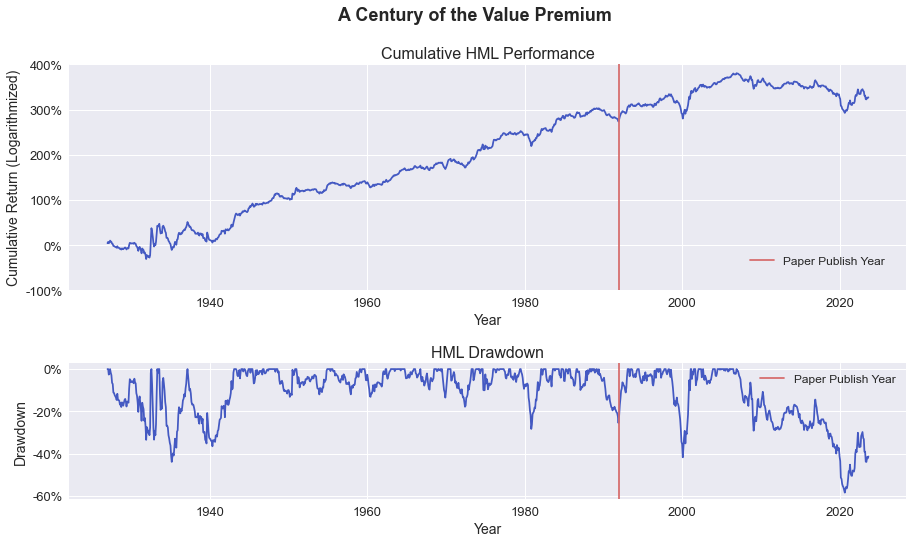

In [4]:
df["HML Cumulative"] = (1+df["HML"]).cumprod()
df["HML Drawdown"] = df["HML Cumulative"] / df["HML Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML Cumulative"]), color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return (Logarithmized)", size=14)
axes[0].tick_params(axis="x", labelsize=13)
yticks = list(range(-1, 5))
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[0].legend(fontsize=12, bbox_to_anchor=(0.8,0.2));

axes[1].plot(df["HML Drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=12, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment.

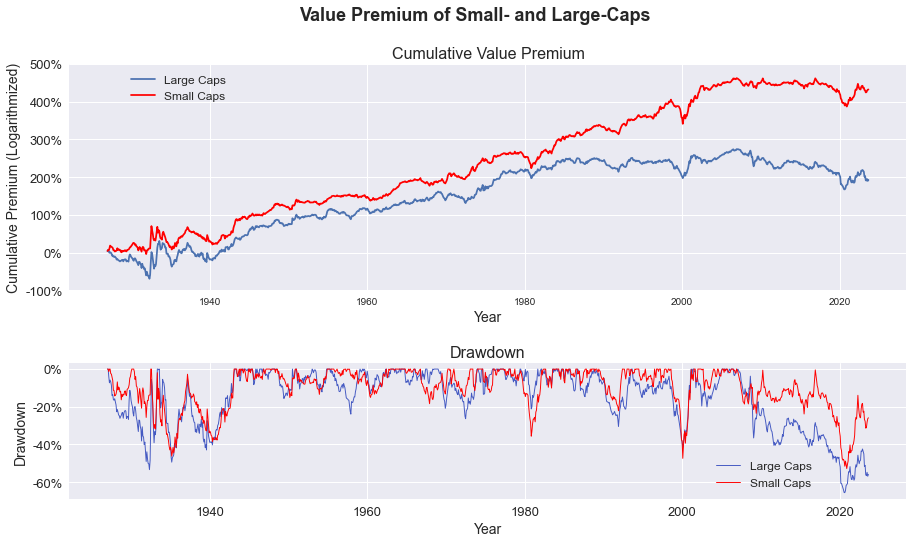

In [5]:
df["Large High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG HiBM"] / 100
df["Large Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG LoBM"] / 100
df["Small High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"] / 100
df["Small Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"] / 100

df["Large Value Premium"] = df["Large High B/M"] - df["Large Low B/M"] 
df["Large Value Premium Cumulative"] = (1+df["Large Value Premium"]).cumprod()
df["Small Value Premium"] = df["Small High B/M"] - df["Small Low B/M"]
df["Small Value Premium Cumulative"] = (1+df["Small Value Premium"]).cumprod()

df["Large Value Premium Drawdown"] = df["Large Value Premium Cumulative"] / df["Large Value Premium Cumulative"].cummax() - 1
df["Small Value Premium Drawdown"] = df["Small Value Premium Cumulative"] / df["Small Value Premium Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premium of Small- and Large-Caps", fontsize=18, fontweight="bold")

axes[0].plot(np.log((1+df["Large Value Premium"]).cumprod()), label="Large Caps")
axes[0].plot(np.log((1+df["Small Value Premium"]).cumprod()), label="Small Caps", color="red")

axes[0].set_title("Cumulative Value Premium", size=16)
axes[0].set_xlabel("Year", fontsize=14)
axes[0].set_ylabel("Cumulative Premium (Logarithmized)", fontsize=14)

yticks = list(range(-1, 6))
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].legend(fontsize=12, bbox_to_anchor=(0.2, 1))

axes[1].plot(df["Large Value Premium Drawdown"], color="#4459c2", linewidth=0.95, label="Large Caps")
axes[1].plot(df["Small Value Premium Drawdown"], color="red", linewidth=0.95, label="Small Caps")

axes[1].set_title("Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12, bbox_to_anchor=(0, 0, 0.9, 0.98));

While some people argue that book values are a flawed measure of valuations as highly profitable technology companies with low capital requirements and hence low book values become more relevant today, the drawdowns look similar if we take net earnings (E/P) or cashflows (CF/P) instead of book values.
<br>
However, the recent drawdowns of value premia based on E/P and CF/P start a few years later and are not as large in magnitude as the recent drawdown of the book-value-based value premium.
<br>
*(Note that the data for other variables is constrained to a later starting date)*

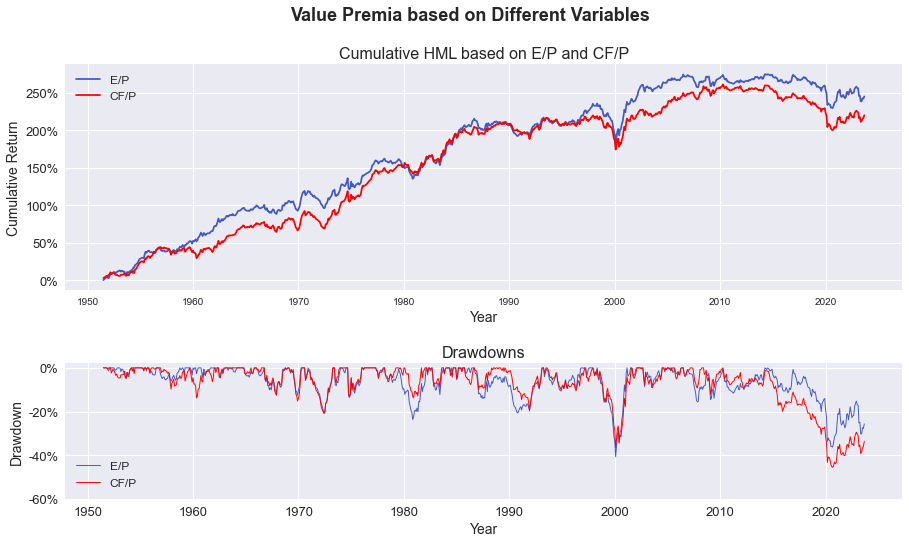

In [6]:
df["Large Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoEP"]) / 100
df["Large Value Premium E/P Cumulative"] = (1+df["Large Value Premium E/P"]).cumprod()
df["Small Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoEP"]) / 100
df["Small Value Premium E/P Cumulative"] = (1+df["Small Value Premium E/P"]).cumprod()

df["HML E/P"] = (df["Large Value Premium E/P"] + df["Small Value Premium E/P"]) / 2
df["HML E/P Cumulative"] = (1+df["HML E/P"]).cumprod()
df["HML E/P Drawdown"] = df["HML E/P Cumulative"] / df["HML E/P Cumulative"].cummax() - 1

df["Large Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoCFP"]) / 100
df["Large Value Premium CF/P Cumulative"] = (1+df["Large Value Premium CF/P"]).cumprod()
df["Small Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoCFP"]) / 100
df["Small Value Premium CF/P Cumulative"] = (1+df["Small Value Premium CF/P"]).cumprod()

df["HML CF/P"] = (df["Large Value Premium CF/P"] + df["Small Value Premium CF/P"]) / 2
df["HML CF/P Cumulative"] = (1+df["HML CF/P"]).cumprod()
df["HML CF/P Drawdown"] = df["HML CF/P Cumulative"] / df["HML CF/P Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, figsize=(15,8), gridspec_kw={'height_ratios': [5,3]})
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premia based on Different Variables", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML E/P Cumulative"]), color="#4459c2", label="E/P")
axes[0].plot(np.log(df["HML CF/P Cumulative"]), color="red", label="CF/P")
axes[0].set_title("Cumulative HML based on E/P and CF/P", size=16)
yticks = [0, 0.5, 1, 1.5, 2, 2.5]
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].legend(fontsize=12)

axes[1].plot(df["HML E/P Drawdown"], color="#4459c2", linewidth=0.95, label="E/P")
axes[1].plot(df["HML CF/P Drawdown"], color="red", linewidth=0.95, label="CF/P")

axes[1].set_title("Drawdowns", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12);

The correlations between alternative measures of the value premium also highlight that it does not matter which fundamental variable we use to measure the value premium. Cheap stocks simply underperformed during the last 15 years.

In [7]:
np.round(df[["HML", "HML E/P", "HML CF/P"]].corr(), 2)

,HML,HML E/P,HML CF/P
HML,1.00,0.85,0.83
HML E/P,0.85,1.00,0.90
HML CF/P,0.83,0.90,1.00


To sum it up, the value factor has been terrible the last decase, no matter of the size of the companies and the variable used. However, there are at least two arguments, considered individually or together, that might invalidate the claim that the recent data points to a vanished value premium:
1. The underperformance is the result of chance.
2. Macroeconomic/fundamentals shifts affected cheap and expensive stocks differently, resulting either in changing valuations or in different unexpected underlying fundamental performances of the companies.

## 2.&nbsp;Stochastic&nbsp;Analysis

Given that all factors carry a sizable amount of risk in the form of volatility, it should be no surprise that a factor, described by a stochastic process with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white-noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of 2% that the process realizes a mean return lower than 0% over a period of 15 years. Likewise, the US market portfolio showed multiple periods of 15-year underperformance against bonds.
<br>
To see whether the underperformance is due to chance, one can compute the p-values of the realized premium, given the prior return distribution.

Pior to publication in 1992, the value premium had delivered an average monthly excess return of

In [8]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [9]:
prior_std = df.loc[:"1992-01-01", "HML"].std()
print(f"{prior_std:.2%}.")

3.69%.


Assuming a gaussian distribution and stationarity between pre- and post-publication (i.e. the same mean and volatility pre- and post-publication), we can compute the probability that the value premium returns an average return below the realized average post-publication return. 
<br>
Considering the increasing number of factor ETFs to give retail investors access to alternative factor premia and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [10]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 381 months.
The sample size spanning from January 1997 to today is 321 months.
The sample size spanning from January 2002 to today is 261 months.
The sample size spanning from January 2007 to today is 201 months.


Turning to the probabilities, we get the following values.

In [11]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.20% per month is 9.51%
For the subsample from January 1997 to today, the probability of an average return less than 0.09% per month is 4.49%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 1.18%
For the subsample from January 2007 to today, the probability of an average return less than -0.21% per month is 0.42%


So far, one could certainly (and possibly unsurpringly) conclude at some reasonable confidence level that the value premium has a structural break (i.e. a linear mean-shift over time as investors adapt to reserach) between pre- and post-publication of the paper.
However, running the same for a hypothesis of a zero mean-return post-publication gives the following results:

In [12]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.20% per month is 87.40%
For the subsample from January 1997 to today, the probability of an average return less than 0.09% per month is 68.10%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 47.41%
For the subsample from January 2007 to today, the probability of an average return less than -0.21% per month is 19.15%


Therefore, based on the assumptions and the data, it is not possible to argue that the value premium is zero.
<br>
One issue though is that the empirical distribution of the value premium, like many financial time-series, is non-normal, although I assumed normality until now.

Its skewness is

In [13]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
np.round(prior_skew, 2)

2.74

and its excess kurtosis is

In [14]:
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
print(np.round(prior_kurt, 2), ",", sep="")

22.94,


both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution at the 1% level:

In [15]:
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also highlights the empirical leptokurtic structure:

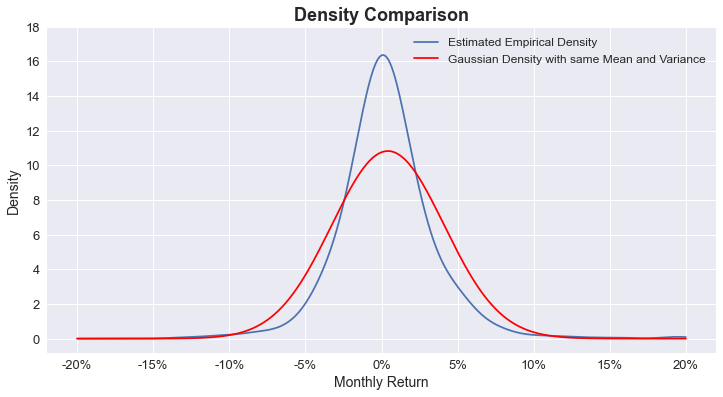

In [16]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])
x = np.linspace(-0.2, 0.2, 1000)

fig, ax = plt.subplots()
ax.plot(x, estimated_density(x), label="Estimated Empirical Density")
ax.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same Mean and Variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = [no/100 for no in range(-20, 21, 5)]
ax.set_xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = list(range(-2, 19, 2))
ax.set_yticks(yticks[1:], yticks[1:], fontsize=13)
ax.set_yticklabels([int(obs) for obs in yticks[1:]], fontsize=13)

ax.legend(fontsize=12);

Therefore, it is important to account for non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and compute the probability of an average return less than the respective realized return by counting the ocurrences and diving it by the total number of bootstrap samples:

In [17]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.0427,0.0147,0.0164,-0.0171,-0.0039,-0.0028,0.0033,-0.0122,-0.0040,-0.0281,...,-0.0116,-0.0155,-0.0101,-0.0014,-0.0116,-0.0353,-0.0132,0.0338,-0.0029,0.0040
1,-0.0512,0.0399,0.0262,0.0033,-0.0242,-0.0113,-0.0160,-0.0215,0.0295,-0.0316,...,-0.0259,-0.0042,0.0427,0.0406,-0.0279,-0.0123,0.0434,-0.0006,-0.0150,-0.0101
2,0.0582,0.0516,-0.0547,-0.0375,0.0059,-0.0074,-0.0294,0.0036,-0.0144,0.0591,...,-0.0444,-0.0370,-0.0242,0.0027,0.0059,-0.0013,0.0232,-0.0116,-0.0215,0.0117
3,-0.0029,-0.0127,0.0015,0.0053,0.0407,0.0097,0.0060,-0.0033,0.0161,0.0148,...,-0.0010,0.0177,0.0060,-0.0119,0.0036,-0.0028,-0.0211,-0.0033,-0.0032,-0.0330
4,0.2222,-0.0279,-0.0402,-0.0215,0.0040,0.0248,-0.0051,-0.0171,0.0281,-0.0833,...,-0.0353,0.0344,-0.0123,0.0036,-0.0052,-0.0140,-0.0292,0.0399,-0.0410,-0.0421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,0.0430,-0.0092,0.0007,0.0198,-0.0029,0.0278,-0.0093,-0.0010,0.0818,-0.0070,...,-0.0248,0.0424,0.0278,-0.0006,0.0040,-0.0189,-0.0131,0.0192,0.0228,0.0754
377,-0.0265,-0.0113,-0.0444,-0.0144,0.0097,0.0085,0.0381,-0.1070,0.0085,0.0020,...,0.0095,0.0383,-0.0123,-0.0187,-0.0591,-0.0009,-0.0025,-0.0030,0.0450,0.0103
378,0.0019,0.0203,-0.0039,-0.0228,-0.0046,-0.0047,-0.0058,0.0736,-0.0531,-0.0054,...,0.0157,-0.0248,-0.0159,0.0327,0.0554,0.0095,0.0248,-0.0035,0.0049,0.0636
379,-0.0034,-0.0736,-0.0196,0.0102,0.0232,-0.0003,-0.0542,0.0228,0.0454,0.0227,...,0.0462,-0.0170,-0.0535,0.0085,0.0059,-0.0065,-0.0034,0.0118,0.0112,-0.0013


In [18]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.20% per month is 11.45%
For the subsample from January 1997 to today, the probability of an average return less than 0.09% per month is 4.95%
For the subsample from January 2002 to today, the probability of an average return less than -0.01% per month is 2.36%
For the subsample from January 2007 to today, the probability of an average return less than -0.21% per month is 0.45%


And the same results in graphical representation look as follows:

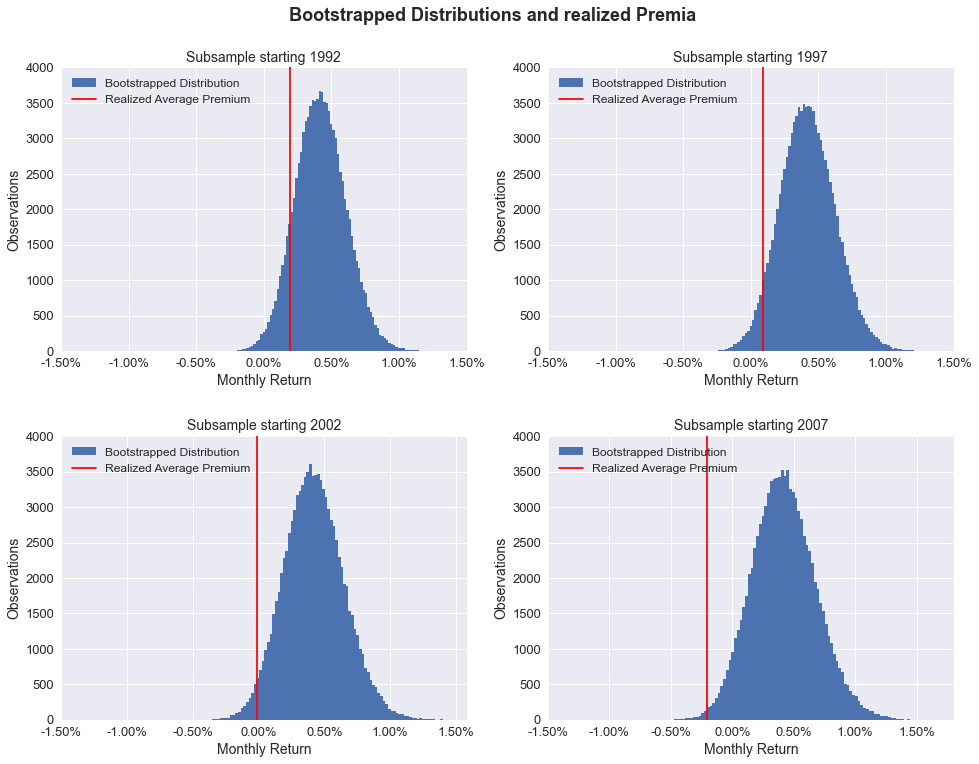

In [19]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=100, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=13)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=13)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than under the normality assumption, the main message remains the same and the post-publication value premium is either a statistical outlier or the process exhibits a structural mean-shift between pre- and post-publication.
<br>
However, as I have shown, the hypothesis that the post-publication mean return is zero cannot be rejected.

## 3.&nbsp;Relative&nbsp;Valuations

While a basket of stocks with the same characteristics (e.g. same magnitude of market beta) should deliver its expected premium over the long term, it can deviate quite a lot from that over the shorter term for various reasons. Valuations of stocks change continuously as the business cycle affects the discount rate, the risk appetite and new news getting priced in.
<br>
The shorter the period, the higher is the effect of changing valuations compared to the embedded premium on returns.
For example, the daily equity premium is a few basis points and the volatility of around 100 basis points dominates, but over decades, positive and negative shocks cancel each other out and the premium overweighs. Following the financial crisis 2008/09, the realized US equity premium was well above its historical average since it has benefited a lot from changes in valuations.

The US equity premium from 1927 to today was

In [20]:
equity_premium = df["Mkt-RF"].mean()*12
print(f"{equity_premium:.2%},")

8.01%,


while the average from 2009 to today was

In [21]:
equity_premium_recent = df.loc["2009-01-01": , "Mkt-RF"].mean()*12
print(f"{equity_premium_recent:.2%},")

13.10%,


or

In [22]:
sigma = ((df["Mkt-RF"].std() * np.sqrt(12)) / np.sqrt(df.loc["2009-01-01": , "Mkt-RF"].count()/12))
np.round((equity_premium_recent - equity_premium) / sigma, 2)

1.05

standard deviations above its expected value using the full sample mean and assuming normality.

Accordingly, a large portion of US stock returns since 2009 have been the result of changing valuations, measured in terms of the [CAPE](https://www.nber.org/system/files/working_papers/w8221/w8221.pdf) (which is a function of risk aversion and expected volatility, profitability and earnings growth), and not by fundamental drivers such as abnormally high realized earnings growth or dividends.

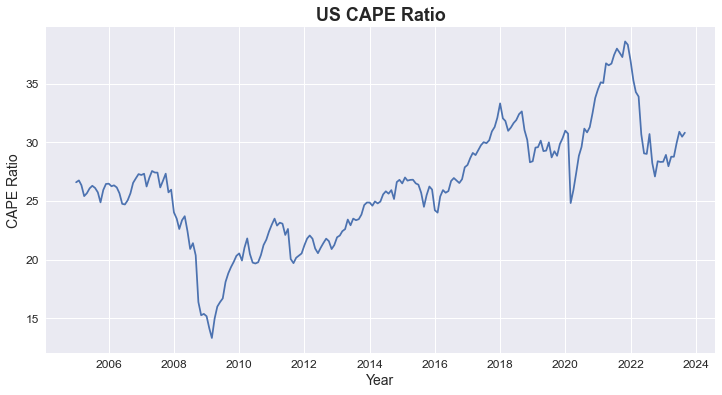

In [23]:
plt.plot(cape.loc["2005-01-01":])

plt.title("US CAPE Ratio", fontsize=18, fontweight="bold")
plt.ylabel("CAPE Ratio", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In a similar fashion, the realized value premium is the result of three factors:
1. The difference of the ex-ante risk premia between cheap and expensive stocks
2. The change in relative valuations due to changing expectations
3. Unexpected fundamental changes that do not affect the relative valuations, e.g. a one-time shock that affect earnings but do not affect expectations going forward and hence also not affect relative valuations
<br>

Again, over a long enough sample, (2) and (3) should have little effect, but over the short term, they can be the main driver of the value premium.

Starting with the question whether cheap stocks are historically cheap or expensive stocks are historically expensive, we can compute the z-score of the respective valuation metric (book-value/market-cap, earnings/price, cashflow/price). Because I use variable/market value instead of the often cited reciprocal (e.g. price/earnings multiple), positive z-scores indicate historically cheap valuations since one gets more fundamental value per amount of market value.
<br>
I use 30th-percentile and 70th-percentile data for expensive and cheap stocks, respectively, provided by Kenneth French on an annual basis computed at the end of June, fill the data in-between with the realized value premium and cut the sample to 1950 onwards because the great depression period of the 1920s has been an extreme outlier in terms of valuation spreads.

In [24]:
bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

bm_size_5_5_sorted_data = FrenchReader("25_Portfolios_5x5").read()

In [25]:
spreads = pd.DataFrame(index = df.index)

#bm_sorted_data["Value Weight Average of BE / ME"].index = bm_sorted_data["Value Weight Average of BE / ME"].index.shift(-1, freq="M")
#bm_sorted_data["Value Weight Average of BE / ME"] = bm_sorted_data["Value Weight Average of BE / ME"].resample("BMS").last().dropna()

spreads["High B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Hi 30"]
spreads["Low B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Lo 30"]

spreads["Large High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["BIG HiBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Large Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["BIG LoBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Small High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["SMALL HiBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Small Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["SMALL LoBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]

for i, index in enumerate(df.index):
    if index in bm_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High B/M Ratio"]):
            spreads.loc[index, "High B/M Ratio"] = spreads.loc[df.index[i-1], "High B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low B/M Ratio"]):
            spreads.loc[index, "Low B/M Ratio"] = spreads.loc[df.index[i-1], "Low B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in bm_size_sorted_data["Average Value Weighted Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High B/M Ratio"]):
            spreads.loc[index, "Large High B/M Ratio"] = spreads.loc[df.index[i-1], "Large High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG HiBM"]/100)
        if np.isnan(spreads.loc[index, "Large Low B/M Ratio"]):
            spreads.loc[index, "Large Low B/M Ratio"] = spreads.loc[df.index[i-1], "Large Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG LoBM"]/100)
        if np.isnan(spreads.loc[index, "Small High B/M Ratio"]):
            spreads.loc[index, "Small High B/M Ratio"] = spreads.loc[df.index[i-1], "Small High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL HiBM"]/100)
        if np.isnan(spreads.loc[index, "Small Low B/M Ratio"]):
            spreads.loc[index, "Small Low B/M Ratio"] = spreads.loc[df.index[i-1], "Small Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL LoBM"]/100)


#ep_sorted_data["Value Weight Average of E / ME"].index = ep_sorted_data["Value Weight Average of E / ME"].index.shift(-1, freq="M")
#ep_sorted_data["Value Weight Average of E / ME"] = ep_sorted_data["Value Weight Average of E / ME"].resample("BMS").last().dropna()

spreads["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
spreads["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]

#ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"].index = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"].index.shift(-1, freq="M")
#ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"].resample("BMS").last().dropna()

spreads["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
spreads["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
spreads["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
spreads["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]

for i, index in enumerate(df.index):
    if index in ep_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High E/P Ratio"]):
            spreads.loc[index, "High E/P Ratio"] = spreads.loc[df.index[i-1], "High E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low E/P Ratio"]):
            spreads.loc[index, "Low E/P Ratio"] = spreads.loc[df.index[i-1], "Low E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in ep_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High E/P Ratio"]):
            spreads.loc[index, "Large High E/P Ratio"] = spreads.loc[df.index[i-1], "Large High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiEP"]/100)
        if np.isnan(spreads.loc[index, "Large Low E/P Ratio"]):
            spreads.loc[index, "Large Low E/P Ratio"] = spreads.loc[df.index[i-1], "Large Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoEP"]/100)
        if np.isnan(spreads.loc[index, "Small High E/P Ratio"]):
            spreads.loc[index, "Small High E/P Ratio"] = spreads.loc[df.index[i-1], "Small High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiEP"]/100)
        if np.isnan(spreads.loc[index, "Small Low E/P Ratio"]):
            spreads.loc[index, "Small Low E/P Ratio"] = spreads.loc[df.index[i-1], "Small Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoEP"]/100)

#cfp_sorted_data["Value Weight Average of CF / ME"].index = cfp_sorted_data["Value Weight Average of CF / ME"].index.shift(-1, freq="M")
#cfp_sorted_data["Value Weight Average of CF / ME"] = cfp_sorted_data["Value Weight Average of CF / ME"].resample("BMS").last().dropna()

spreads["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
spreads["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]

#cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"].index = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"].index.shift(-1, freq="M")
#cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"].resample("BMS").last().dropna()

spreads["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
spreads["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
spreads["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
spreads["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]

for i, index in enumerate(df.index):
    if index in cfp_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High CF/P Ratio"]):
            spreads.loc[index, "High CF/P Ratio"] = spreads.loc[df.index[i-1], "High CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low CF/P Ratio"]):
            spreads.loc[index, "Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Low CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
            
    if index in cfp_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High CF/P Ratio"]):
            spreads.loc[index, "Large High CF/P Ratio"] = spreads.loc[df.index[i-1], "Large High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Large Low CF/P Ratio"]):
            spreads.loc[index, "Large Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Large Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoCFP"]/100)
        if np.isnan(spreads.loc[index, "Small High CF/P Ratio"]):
            spreads.loc[index, "Small High CF/P Ratio"] = spreads.loc[df.index[i-1], "Small High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Small Low CF/P Ratio"]):
            spreads.loc[index, "Small Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Small Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoCFP"]/100)

spreads = spreads["1950-01-01":]

In [26]:
z_scores = {
    "High": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"]),
    "Low": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"])
}
z_scores["High"].index.name = "Cheap Stocks"
z_scores["Low"].index.name = "Expensive Stocks"
for breakpoint in z_scores.keys():
    for var in z_scores[breakpoint].index:
        for cap in z_scores[breakpoint].columns:
            if cap == "All":
                name = f"{breakpoint} {var} Ratio"
            else:
                name = f"{cap} {breakpoint} {var} Ratio"
            z_scores[breakpoint].loc[var, cap] = (spreads[name][-1] - spreads[name].mean()) / spreads[name].std()
display(z_scores["High"].applymap(lambda x: round(x, 2)))
display(z_scores["Low"].applymap(lambda x: round(x, 2)))

,All,Large,Small
Cheap Stocks,,,
B/M,-0.39,-0.38,-0.18
E/P,0.95,0.84,2.00
CF/P,0.49,0.40,1.25


,All,Large,Small
Expensive Stocks,,,
B/M,-1.41,-1.37,-0.92
E/P,-0.82,-0.80,-0.88
CF/P,-1.04,-1.05,-0.91


Both cheap and expensive stocks are rich compared to their historical averages, which, given the current low rate environment, is not suprising. However, expensive stocks seem to be disproportionately expensive based on all three metrics.
<br>
*Update November 2022: Based on earnings, cheap stocks are now cheap relative to their historical averages. Expensive stocks remain relatively expensive however.*

To gain further insight, we can take a look at the relative valuations of stocks with high book-to-market ratios and those with low book-to-market ratios, both in small- and large-caps. I compute those ratios by diving the average book-to-market of cheap stocks by the average book-to-market of expensive stocks.

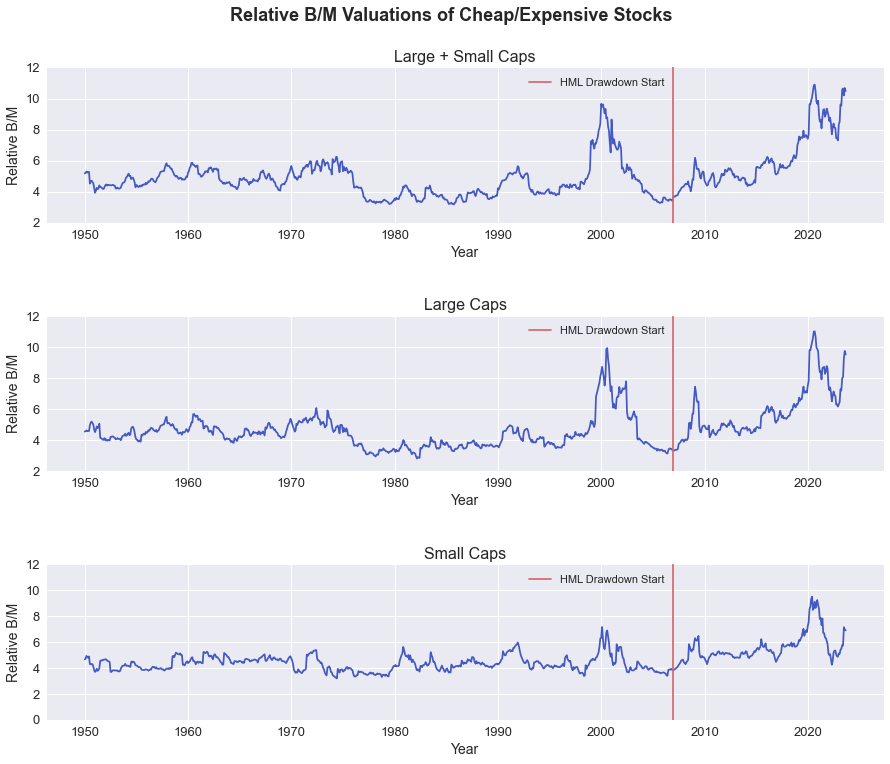

In [27]:
spreads["Valuation Spread All"] = spreads["High B/M Ratio"] / spreads["Low B/M Ratio"]
spreads["Valuation Spread Large"] = spreads["Large High B/M Ratio"] / spreads["Large Low B/M Ratio"]
spreads["Valuation Spread Small"] = spreads["Small High B/M Ratio"] / spreads["Small Low B/M Ratio"]

figure, axes = plt.subplots(3, figsize=(15,12))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative B/M Valuations of Cheap/Expensive Stocks", fontsize=18, fontweight="bold", y=0.95)

axes[0].plot(spreads["Valuation Spread All"], color="#4459c2")
axes[0].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[0].set_title("Large + Small Caps", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Relative B/M", size=14)
axes[0].tick_params(axis="x", labelsize=13)
axes[0].tick_params(axis="y", labelsize=13)
axes[0].set_yticks(list(range(2,13,2)))

axes[0].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

axes[1].plot(spreads["Valuation Spread Large"], color="#4459c2")
axes[1].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[1].set_title("Large Caps", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Relative B/M", size=14)
axes[1].tick_params(axis="x", labelsize=13)
axes[1].tick_params(axis="y", labelsize=13)
axes[1].set_yticks(list(range(2,13,2)))

axes[1].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

axes[2].plot(spreads["Valuation Spread Small"], color="#4459c2")
axes[2].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[2].set_title("Small Caps", size=16)
axes[2].set_xlabel("Year", size=14)
axes[2].set_ylabel("Relative B/M", size=14)
axes[2].tick_params(axis="x", labelsize=13)
axes[2].tick_params(axis="y", labelsize=13)
axes[2].set_yticks(list(range(0,13,2)))

axes[2].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

It becomes clear that relative valuations increased dramatically since the start of the HML drawdown in January 2007 with relative valuations widening between 200% and 250% and that the current level is similar to that of the 2000 dotcom bubble and the great depression in the 1930s (which is left out for presentation purposes).

The picture looks similar when using net earnings or cashflows as the fundamental variable instead of book-values, although the widening is not as significant as for book-values.

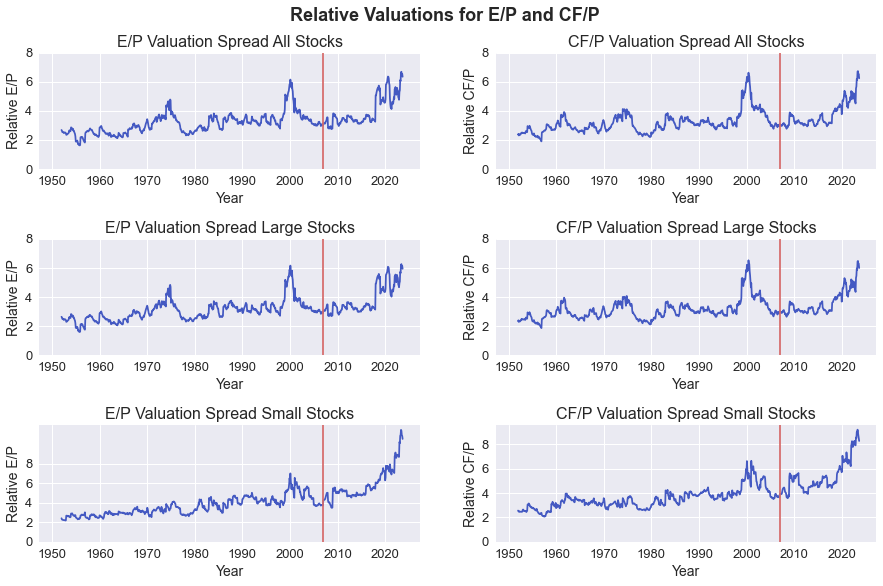

In [28]:
spreads["E/P Valuation Spread All"] = spreads["High E/P Ratio"] / spreads["Low E/P Ratio"]
spreads["E/P Valuation Spread Large"] = spreads["Large High E/P Ratio"] / spreads["Large Low E/P Ratio"]
spreads["E/P Valuation Spread Small"] = spreads["Small High E/P Ratio"] / spreads["Small Low E/P Ratio"]
spreads["CF/P Valuation Spread All"] = spreads["High CF/P Ratio"] / spreads["Low CF/P Ratio"]
spreads["CF/P Valuation Spread Large"] = spreads["Large High CF/P Ratio"] / spreads["Large Low CF/P Ratio"]
spreads["CF/P Valuation Spread Small"] = spreads["Small High CF/P Ratio"] / spreads["Small Low CF/P Ratio"]

figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative Valuations for E/P and CF/P", fontsize=18, fontweight="bold", y=0.95)

for row, dataset in enumerate((
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small"
)):

    axes[row, 0].plot(spreads[dataset], color="#4459c2")
    axes[row, 0].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 0].set_title(f"{dataset} Stocks", size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    yticks = list(range(0,9,2))
    axes[row, 0].set_yticks(yticks)
    axes[row, 0].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 0].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, dataset in enumerate((
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)):
    axes[row, 1].plot(spreads[dataset], color="#4459c2")
    axes[row, 1].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 1].set_title(f"{dataset} Stocks", size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    yticks = list(range(0,9,2))
    axes[row, 1].set_yticks(yticks)
    axes[row, 1].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 1].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

This indicates that the value premium during the last 15 years was to a large extent driven by changing relative valuations between cheap and expensive stocks. Hence, the "fundamental" value premium that accounts for unexpected changes in the explaining factors of relative valuations might not have been as bad as it first seems when looking solely at the data.

## 4.&nbsp;Explaining&nbsp;Variables

Because the change in relative valuations of cheap and expensive stocks has a significant impact on the realized premium, we should analyze the value premium adjusted for changes in the state vector that contains variables that describe the current market environment and affect relative valuations.
<br>
The naive way to do so is to adjust the premium by subtracting the change in valuation. For example, when the value premium returns 100% and expensive stocks double their relative valuation compared to cheap stocks, the adjusted premium would be zero. However, this would ignore changes that also justify changes in relative valuations (such as expensive stocks becoming more profitable) and the adjusted premium would be biased.
<br>
A better way is therefore to find variables that affect relative valuations, adjust the valuation spread to those variables and subtract the adjusted valuation spread from the value premium to compute a "fundamental" value premium.
<br>
<br>
Starting with the simple pricing equation, any asset price should equal the sum of all excess cashflows it will generate during its lifetime, discounted to the present.
<br>
<br>
$$ Market\;Value = \sum \limits_{t=1} ^{\infty} \frac{Free\;Cashflow_t}{(1+Discount\;Rate_t)^{t}} $$
<br>
Assuming a flat term structure of discount rates, a constant growth rate of free-cashflows and that the discount rate is higher than the growth rate, the resulting geometric series can be simplified to
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Discount\;Rate-Growth\;Rate} $$
<br>
The discount rate of any asset consists of its risk premium and the rate one would get on a riskless asset.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Growth\;Rate} $$
<br>
The growth rate of free cashflows is governed by the reinvestment rate scaled by profitability. If all earnings are reinvested with a return on invested capital (ROIC) of 10%, then the growth rate of free cashflows and earnings has to be 10%. Likewise, if only 50% of cashflows are reinvested, the growth rate would be 5%.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*ROIC} $$
<br>
Rearranging gives
<br>
<br>
$$ \frac{Free\;Cashflow}{Market\;Value} = Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*ROIC $$

The conclusion is that the amount of earnings, cashflows or book-value one gets for every amount of market value increases with the risk-free rate, increases with the risk premium and decreases with the profitability.
<br>
Terefore the valuation spread between cheap and expensive stocks (e.g. book-to-market ratios of cheap stocks divided by book-to-market ratios of expensive stocks)
1. **increases** with the risk premium differential between cheap and expensive stocks
2. **decreases** with the profitability difference between cheap and expensive stocks
*The relationship between valuation ratios and reinvestment rate depends on the values of the discount rate and profitability. Because Kenneth French does not provide data on reinvestment rates anyways, I ignore it.*

In addition, expensive stocks tend to grow faster than cheap stocks and hence have a higher portion of their net present value in the distant future than cheap stocks. That is why expensive stocks are more interest-rate sensitive (i.e. have a higher duration) than cheap stocks. For example, at a discount rate of 5%, the net present value of 100 dollar in 10 (30) years would be 61.39 (23.14). An increase of 1% in the discount rate would change net present values to 55.84 and 17.41, resulting in relative changes of -9.05% and -24.76%, respectively.
<br>
Because risk-free rates are generally not constant across all maturities, cashflows across different maturities are discounted with different rates. The implication is that even though the yield curve shifts upwards, cheap stocks could drop more than expensive stocks if short-term rates rise much faster (or drop much less) than long-term rates.
<br>
We can hence disentangle the partial effects of the yield curve on valuation spreads by stating that

3. the **higher** the level of the yield curve (i.e. the T-bill or short-term T-note rate), the **lower** are valuation spreads of cheap and expensive stocks
4. the **steeper** the slope of the yield curve (i.e. the higher the difference between long-term rates and short-term rates), the **lower** are valuation spreads of expensive and cheap stocks

To analyze the impact of each variable, I use the 1-year interest rate as the level of the yield curve and the difference between the 10-year interest rate and the 1-year interest rate as the slope of the yield curve.
<br>
*I ignore the impact of operating profitability for now as it gives ambiguous results.*

In [29]:
spread_labels = (
    "Valuation Spread All",
    "Valuation Spread Large",
    "Valuation Spread Small",
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small",
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)
ols_df = pd.DataFrame(index=bm_size_sorted_data["Value Weight Average of OP"].index)
for ts in spread_labels:
    ols_df[ts] = spreads[ts]
ols_df = ols_df.dropna()
ols_df["1-Year Interest Rate"] = rate_1yr
ols_df["10-Year Interest Rate"] = rate_10yr
ols_df["Level"] = ols_df["1-Year Interest Rate"]
ols_df["Slope"] = ols_df["10-Year Interest Rate"] - ols_df["1-Year Interest Rate"]
ols_df["Large Cheap Profitability"] = bm_size_sorted_data["Value Weight Average of OP"]["BIG HiBM"]
ols_df["Large Expensive Profitability"] = bm_size_5_5_sorted_data["Value Weight Average of OP"]["ME5 BM2"]
ols_df["Small Cheap Profitability"] = bm_size_sorted_data["Value Weight Average of OP"]["SMALL HiBM"]
ols_df["Small Expensive Profitability"] = bm_size_5_5_sorted_data["Value Weight Average of OP"]["ME1 BM2"]

In [30]:
adjusted_spreads = {}
ols_results = pd.DataFrame(columns = ["Level", "Slope", "R^2"], index = spread_labels)
ols_results.index.name = "Significance Level: 10%: *, 5%: **, 1%: ***"
for series in spread_labels:
    res = OLS(
        np.log(ols_df[series]),
        add_constant(ols_df[["Level", "Slope"]])
    ).fit()
    params = res.params
    pvalues = res.pvalues
    for var in ("Level", "Slope"):
        if pvalues[var] < 0.01:
            significance = "***"
        elif pvalues[var] < 0.05:
            significance = "**"
        elif pvalues[var] < 0.1:
            significance = "*"
        else:
            significance = ""
        ols_results.loc[series, var] = "{:.2f}{}".format(params[var], significance)
    ols_results.loc[series, "R^2"] = f"{res.rsquared_adj:.2f}"
    adjusted_spreads[series] = res.resid

for sample in ("All", "Large", "Small"):
    adjusted_spreads[f"Average Valuation Spread {sample}"] = (adjusted_spreads[f"Valuation Spread {sample}"]*2 + adjusted_spreads[f"E/P Valuation Spread {sample}"] + adjusted_spreads[f"CF/P Valuation Spread {sample}"])/4
ols_results

,Level,Slope,R^2
"Significance Level: 10%: *, 5%: **, 1%: ***",,,
Valuation Spread All,-5.32***,-10.30***,0.34
Valuation Spread Large,-5.52***,-8.43***,0.36
Valuation Spread Small,-3.12***,-4.01***,0.24
E/P Valuation Spread All,-2.59***,-4.25***,0.12
E/P Valuation Spread Large,-2.63***,-4.75***,0.13
E/P Valuation Spread Small,-4.67***,-3.07***,0.26
CF/P Valuation Spread All,-2.34***,-3.43***,0.11
CF/P Valuation Spread Large,-2.26***,-3.63***,0.10
CF/P Valuation Spread Small,-4.77***,-3.47***,0.33


Two oberservations are worth noting.
1. As expected, both the level and the slope of the yield curve have a signifant effect on valuation spreads for almost all valuation spreads.
2. Less variance is explained for earnings/price and cashflow/price computed valuation spreads than for book-to-market valuation spreads. This should be expected since earnings and cashflows are noisy and fluctuate much more than book-values.

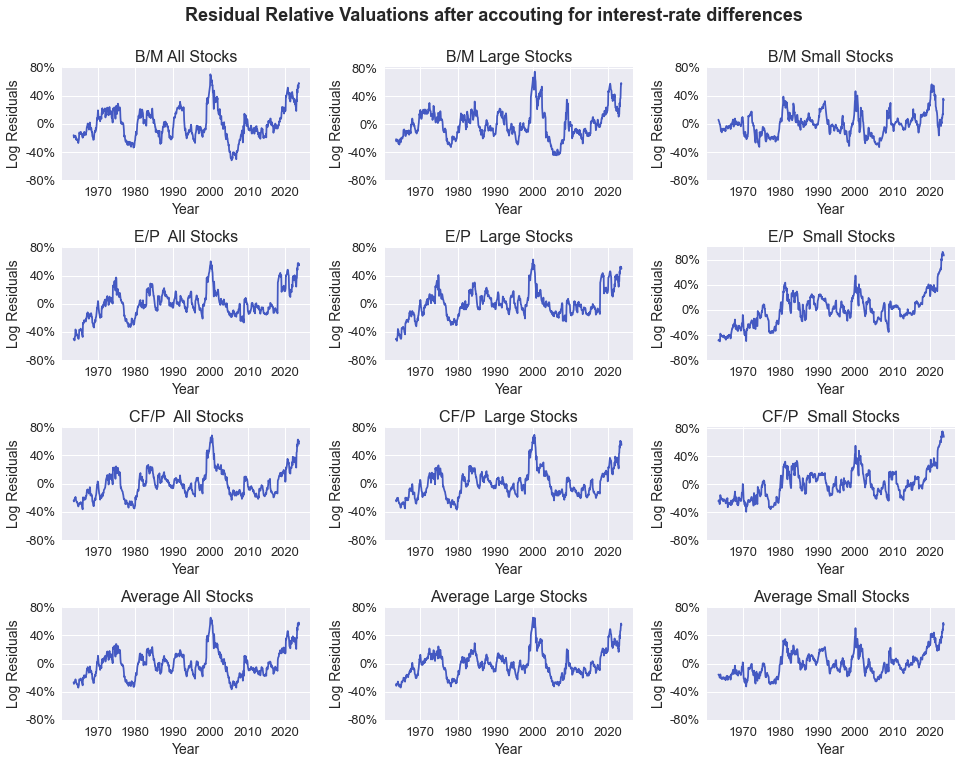

In [31]:
figure, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,12))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
figure.suptitle("Residual Relative Valuations after accouting for interest-rate differences", fontsize=18, fontweight="bold", y=0.95)

for row, variable in enumerate(("", "E/P ", "CF/P ")):
    for col, sample in enumerate(("All", "Large", "Small")):
    
        axes[row, col].plot(adjusted_spreads[f"{variable}Valuation Spread {sample}"], color="#4459c2")
        if variable == "":
            var_name = "B/M"
        else:
            var_name = variable            
        axes[row, col].set_title(f"{var_name} {sample} Stocks", size=16)
        axes[row, col].set_xlabel("Year", size=14)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        axes[row, col].set_yticks(yticks)
        axes[row, col].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
        axes[row, col].set_ylabel("Log Residuals", size=14)
        axes[row, col].tick_params(axis="both", labelsize=13)

for col, sample in enumerate(("All", "Large", "Small")):
        axes[3, col].plot(adjusted_spreads[f"Average Valuation Spread {sample}"], color="#4459c2")      
        axes[3, col].set_title(f"Average {sample} Stocks", size=16)
        axes[3, col].set_xlabel("Year", size=14)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        axes[3, col].set_yticks(yticks)
        axes[3, col].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
        axes[3, col].set_ylabel("Log Residuals", size=14)
        axes[3, col].tick_params(axis="both", labelsize=13)

Adjusting the valuation spreads for the impact of the interest-rate level and the yield curve slope reaffirms the extreme levels. The historically low yield curve is not the major factor behind today's extreme differences between cheap and expensive stock valuations.
<br><br>
As of January 2023, the more persistent book-to-market spread already shows a meaningful mean reversion, particularly in small caps. I leave it open whether the spread in earnings/cashflow-to-price spreads is due to temporary differences in profitability (which would mean that the average spread comes down without any price movement) or whether it is a structural issue between cheap and expensive stocks (which would make the average spreads more important than the B/M spreads).

## 5.&nbsp;Real-Time&nbsp;Perspective

Because data from Kenneth French is updated at the end of each next month, the data is lagged by 1-2 months from real-time. While the lag should not matter that much in a stable market environment since all variables are fairly persistent, I compute valuation spreads nonetheless on a real-time basis because they can divert a lot from lagged data when stock market volatility is high and stock prices rise/fall rapidly even within 2 months.
<br>
To do so, I use a set of value-type and expensive-type MSCI indices where I can compile long historical and real-time data, form long-short portfolios and compute their value factor exposure with the highest R² possible. I then compute the index-mimicked value premium of the last 1-2 months by taking the returns of the long-short index portfolio of the last 1-2 months and divide it by its historical exposure to the value premium by Kenneth French.
<br>
Finally, I divide the respective valuation spread by the cumulative performance of the index-mimicked value premium to compute the current real-time valuation spread.

In [32]:
indices_list = []
for index_name, code in {
    "Small Value": 655133,
    "Small Growth": 655238,
    "Large Value": 650145,
    "Large Growth": 650250
}.items():
    returns = MSCIReader(code, frequency="daily", index_variant="GRTR").historical_data()["data"]["simple_returns"].loc["2001-01-01":]
    returns.name = index_name
    indices_list.append(returns)

indices = pd.concat(indices_list, axis=1).dropna()

In [33]:
start_date = df.index[-1] + pd.DateOffset(months=1)
factors = df[["Mkt-RF", "HML", "Small Value Premium", "Large Value Premium", "Large High B/M"]]
factors.index = factors.index.to_period('M').to_timestamp('M')
premia = pd.concat([factors, (1+indices).cumprod().resample("m").last().pct_change()], axis=1).dropna()

hml_beta = OLS(
    (
        0.5*(premia["Small Value"]-premia["Small Growth"]) +
        0.5*(premia["Large Value"]-premia["Large Growth"])
    ),
    add_constant(premia["HML"])
).fit().params["HML"]

large_hml_beta = OLS(
    premia["Large Value"]-premia["Large Growth"],
    add_constant(premia["Large Value Premium"])
).fit().params["Large Value Premium"]

small_hml_beta = OLS(
    premia["Small Value"]-premia["Small Growth"],
    add_constant(premia["Small Value Premium"])
).fit().params["Small Value Premium"]

mimicked_value_premium = ((
    0.5*(indices["Small Value"]-indices["Small Growth"]) +
    0.5*(indices["Large Value"]-indices["Large Growth"])
) / hml_beta)[start_date:]
mimicked_value_premium.name = "HML OOS"

mimicked_value_premium_large = ((indices["Large Value"]-indices["Large Growth"]) / hml_beta)[start_date:]
mimicked_value_premium_large.name = "Large Value Premium OOS"
mimicked_value_premium_small = ((indices["Small Value"]-indices["Small Growth"]) / hml_beta)[start_date:]
mimicked_value_premium_small.name = "Small Value Premium OOS"

In [34]:
df_rt = pd.concat(
    [
        df[["HML", "Large Value Premium", "Small Value Premium", "Large High B/M"]],
        mimicked_value_premium,
        mimicked_value_premium_large,
        mimicked_value_premium_small,
        spreads[["Valuation Spread All", "E/P Valuation Spread All", "CF/P Valuation Spread All"]],
        spreads[["Valuation Spread Large", "E/P Valuation Spread Large", "CF/P Valuation Spread Large"]],
        spreads[["Valuation Spread Small", "E/P Valuation Spread Small", "CF/P Valuation Spread Small"]]
    ],
    axis=1
)["1950-01-01":]

for premium in ("HML", "Large Value Premium", "Small Value Premium"):
    for i, index in enumerate(df_rt.index):
        if np.isnan(df_rt.loc[index, premium]):
            df_rt.loc[index, premium] = df_rt.loc[index, f"{premium} OOS"]

for spread in ("Valuation Spread All", "E/P Valuation Spread All", "CF/P Valuation Spread All"):
    for i, index in enumerate(df_rt.index):
        if np.isnan(df_rt.loc[index, spread]):
            df_rt.loc[index, spread] = df_rt.loc[df_rt.index[i-1], spread] / (1+df_rt.loc[index, "HML"])

for spread in ("Valuation Spread Large", "E/P Valuation Spread Large", "CF/P Valuation Spread Large"):
    for i, index in enumerate(df_rt.index):
        if np.isnan(df_rt.loc[index, spread]):
            df_rt.loc[index, spread] = df_rt.loc[df_rt.index[i-1], spread] / (1+df_rt.loc[index, "Large Value Premium"])

for spread in ("Valuation Spread Small", "E/P Valuation Spread Small", "CF/P Valuation Spread Small"):
    for i, index in enumerate(df_rt.index):
        if np.isnan(df_rt.loc[index, spread]):
            df_rt.loc[index, spread] = df_rt.loc[df_rt.index[i-1], spread] / (1+df_rt.loc[index, "Small Value Premium"])

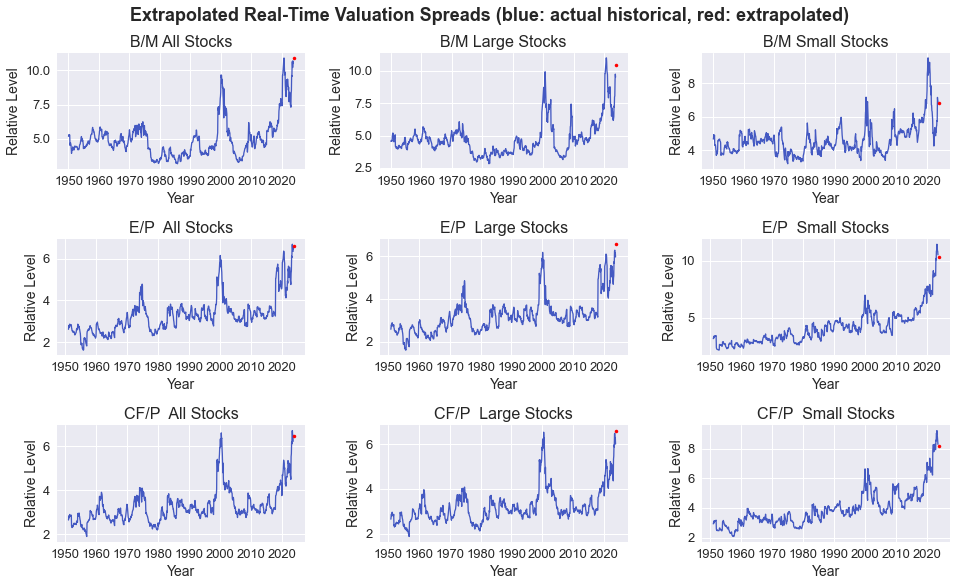

In [35]:
figure, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 9))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
figure.suptitle("Extrapolated Real-Time Valuation Spreads (blue: actual historical, red: extrapolated)", fontsize=18, fontweight="bold", y=0.95)

for row, variable in enumerate(("", "E/P ", "CF/P ")):
    for col, sample in enumerate(("All", "Large", "Small")):
    
        axes[row, col].plot(df_rt[f"{variable}Valuation Spread {sample}"][:start_date], color="#4459c2", linewidth=1.3)
        axes[row, col].plot(df_rt.index[-1], df_rt[f"{variable}Valuation Spread {sample}"][-1], marker=".", color="red", linewidth=1.3)
        if variable == "":
            var_name = "B/M"
        else:
            var_name = variable            
        axes[row, col].set_title(f"{var_name} {sample} Stocks", size=16)
        axes[row, col].set_xlabel("Year", size=14)
        axes[row, col].set_ylabel("Relative Level", size=14)
        axes[row, col].tick_params(axis="both", labelsize=13)

## 6.&nbsp;Time-Series&nbsp;Predictability

To sum it up, today's high valuation spreads indicate that either the expected value premium or the expected growth differential between expensive and cheap stocks is historically high.
<br>
In order to grasp whether valuation spreads have predictive power on the value premium, I first take an in-sample point of view and then take the out-of-sample view an investor would have been faced with in real-time.

First, fitting an AR(1) model on the logarithmized valuation spreads shows a fairly strong mean reversion, although slow-moving, with the autoregressive parameter being significant different from 1 for most spreads. Since valuation spreads should move mainly via the difference in stock returns (especially when using book values as the fundamental variable), statistically significant autoregressive parameters hint at return predictability of the value premium.

In [36]:
ar_results = pd.DataFrame()
for spread in (
    "Valuation Spread All",
    "Valuation Spread Large",
    "Valuation Spread Small",
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small",
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
):
    monthly_fit = ARIMA(np.log(spreads[spread]), order=(1,0,0)).fit()
    yearly_fit = ARIMA(np.log(spreads[spread].resample("y").last()), order=(1,0,0)).fit()
    tvalue_m = (1 - monthly_fit.params['ar.L1']) / (monthly_fit.params['ar.L1']/monthly_fit.tvalues["ar.L1"])
    tvalue_y = (1 - yearly_fit.params['ar.L1']) / (yearly_fit.params['ar.L1']/yearly_fit.tvalues["ar.L1"])
    
    if tvalue_m > 2.56:
        significance = "***"
    elif tvalue_m > 1.96:
        significance = "**"
    elif tvalue_m  > 1.65:
        significance = "*"
    else:
        significance = ""
    ar_results.loc[spread, "ar_monthly"] = f"{monthly_fit.params['ar.L1']:.2f}{significance}"

    if tvalue_y > 2.56:
        significance = "***"
    elif tvalue_y > 1.96:
        significance = "**"
    elif tvalue_y  > 1.65:
        significance = "*"
    else:
        significance = ""
    ar_results.loc[spread, "ar_yearly"] = f"{yearly_fit.params['ar.L1']:.2f}{significance}"
ar_results.index.name = "Significance Level: 10%: *, 5%: **, 1%: ***"
ar_results

,ar_monthly,ar_yearly
"Significance Level: 10%: *, 5%: **, 1%: ***",,
Valuation Spread All,0.99,0.84**
Valuation Spread Large,0.99**,0.82**
Valuation Spread Small,0.97***,0.54***
E/P Valuation Spread All,0.98***,0.77***
E/P Valuation Spread Large,0.98***,0.74***
E/P Valuation Spread Small,0.99,0.91
CF/P Valuation Spread All,0.99**,0.77***
CF/P Valuation Spread Large,0.98***,0.75***
CF/P Valuation Spread Small,0.99*,0.91


Turning to the out-of-sample view an investor would have been faced with in real-time, I follow the procedure of Goyal and Welch (2007). I first take a 20-year estimation window and run the following regression:
<br>
<br>
$$ Equity Premium_{t+1} = \alpha + \beta_{1} *  Valuation Spread_t $$
<br>
After that, I use that estimator and compute the expected value premium the next month given the current valuation spread. I compute the squared forecast error, go one month forward, run the regression again with an additional data point and compute the expected value premium of the next month again. This procedure is done until the end of the sample. I then follow Campbell and Thompson (2007) and compute the OOS-R²:
<br>
<br>
$$ R^{2}_{OOS} = 1 - \frac{MSFE_{u}}{MSFE_{r}} $$
<br>
where $MSFE_{u}$ denotes the mean squared forecast error of the model above and $MSFE_{r}$ denotes the mean squared forecast error of the model above, but setting $beta_{1}$ to 0. In other words, the OOS-R² compares if the conditional fitted value using the valuation spread is on average a better forecast of the value premium than using simply the historical mean. Hence, it tests whether the equity premium is time-varying or stationary and therefore unpredictable.

Remark: The OOS forecast fails completely as the beta is positive (which is expected to be negative, or at least zero). The explanation could be that there is too many noise in the series compared to the sample size. Because of the 2000 dotcom bubble where the value premium was negative for an extended period of time while valuation spreads increased, which resulted in a steep positive relationship (strongly positive outliers of valuation spreads and strongly negative outliers of the value premium), the "true" relationship could be skewed to the upside within that sample. For now, I skip that part and look into it later on.

## 7.&nbsp;ETF/Stock&nbsp;Selection

To set up a trade to harvest the value premium, it is crucial to know what type of stocks or ETFs one should look for, i.e. how high or low the multiples should be. I now use the more common reciprocal multiple and report quantile multiples of price/book, price/earnings and price/cashflow multiples (hence the lower, the better), both for the full sample and distinguished between large and small caps.

In [37]:
multiples_single = pd.DataFrame(columns=["P/E", "P/CF", "P/B"])
for i in range(10, 0, -1):
    if i == 1:
        multiples_single.loc["Highest 10%", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"]["Lo 10"].iloc[-1]
        multiples_single.loc["Highest 10%", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 10"].iloc[-1]
        multiples_single.loc["Highest 10%", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"]["Lo 10"].iloc[-1]
    elif i == 10:
        multiples_single.loc["Lowest 10%", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"]["Hi 10"].iloc[-1]
        multiples_single.loc["Lowest 10%", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 10"].iloc[-1]
        multiples_single.loc["Lowest 10%", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"]["Hi 10"].iloc[-1]
    else:
        multiples_single.loc[f"{(i)/10:.0%}", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"][f"Dec {i}"].iloc[-1]
        multiples_single.loc[f"{(i)/10:.0%}", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"][f"Dec {i}"].iloc[-1]
        multiples_single.loc[f"{(i)/10:.0%}", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"][f"Dec {i}"].iloc[-1]
multiples_single = multiples_single.applymap(lambda x: np.round(x, 2))


multiples_double = pd.DataFrame(
    columns=["P/E", "P/CF", "P/B"],
    index=pd.MultiIndex.from_product([["Large", "Small"], ["Lowest 30%", "70%", "Highest 30%"]])
)
i = 0
for size in range(1, -1, -1):
    for value in range(2, -1, -1):
        multiples_double.loc[multiples_double.index[i], "P/E"] = (1/ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"].iloc[-1, size*3+value])
        multiples_double.loc[multiples_double.index[i], "P/CF"] = (1/cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"].iloc[-1, size*3+value])
        multiples_double.loc[multiples_double.index[i], "P/B"] = (1/bm_size_sorted_data["Value Weight Average of BE/ME"].iloc[-1, size*3+value])
        i += 1
multiples_double = multiples_double.applymap(lambda x: np.round(x, 2))

In [38]:
display(multiples_single)
display(multiples_double)

,P/E,P/CF,P/B
Lowest 10%,3.40,2.88,0.56
90%,5.78,4.88,1.03
80%,8.70,6.80,1.26
70%,11.24,9.52,1.52
60%,14.08,11.49,1.89
50%,17.54,13.70,2.28
40%,20.83,16.39,2.96
30%,25.64,20.83,3.97
20%,34.48,27.78,5.68
Highest 10%,66.67,66.67,14.29


P/E   P/CF   P/B
Large Lowest 30%    6.56   5.06  0.99
      70%          16.53  13.05  2.03
      Highest 30%  32.57  26.95  7.88
Small Lowest 30%    4.58   3.76  0.84
      70%          14.84  11.95  2.05
      Highest 30%  46.73  32.15  5.96

It becomes clear that one should go long a basket of stocks or ETFs with
<br>
1. price/earnings < 11
2. price/cashflows < 10
3. price/book < 1.5

and avoid or short stocks/ETFs with
1. price/earnings > 35
2. price/cashflows > 30
3. price/book > 7

Turning to ETFs for european investors, there are some UCITS-compliant ETFs with significantly positive and negative value-factor loadings, covering the United States, Europe, Emerging Markets and global stock universes.
<br>
For comparison purposes, I report returns in US-Dollar. If someone is long an ETF with US stocks and the EUR/USD exchange rate falls, the ETF would outperform a european counterpart with exactly the same metrics. Therefore, to account for an implicit currency bet, I translate all returns that are not in US-Dollar to USD returns by multiplying the ETF return with the change in the currency rate of that currency to the US-Dollar.

In [39]:
global_factors = FrenchReader("Developed_5_Factors").read()["Main"] / 100
eu_factors = FrenchReader("Europe_5_Factors").read()["Main"] / 100
em_factors = FrenchReader("Emerging_5_Factors").read()["Main"] / 100

eur_usd = YahooReader("EURUSD=X").historical_data(frequency="1d")["data"]["simple_returns"]
eur_usd = (1+eur_usd).cumprod().resample("MS").last().pct_change().dropna()
eur_usd.index = [pd.to_datetime(item.date()) for item in eur_usd.index]

gbp_usd = YahooReader("GBPUSD=X").historical_data(frequency="1mo")["data"]["simple_returns"]
gbp_usd.index = [pd.to_datetime(item.date()) for item in gbp_usd.index]

In [40]:
# Long ETFs
long_etfs = {
    "IE00BJRCLL96": "JPGL.DE",
    "IE00BP3QZB59": "IS3S.DE",
    "IE00BL25JM42": "XDEV.DE",
    "IE00BSPLC413": "ZPRV.DE",
    "IE00BSPLC298": "ZPRX.DE",
    "IE00BF2B0K52": "FLXE.DE",
    "IE00BG0SKF03": "5MVL.DE",
    "IE00BQZJBM26": "WTED.DE"
}

long_etf_exposures = pd.DataFrame(columns=["Name", "ISIN", "MKT", "SMB", "HML", "RMW", "R2", "Residual Volatility", "Return since Jan 2022"])
long_etf_exposures.index.name = "Ticker"
etf_list = []
for isin, ticker in long_etfs.items():
    reader = OnvistaFundReader(isin)
    name = reader.name
    long_etf_exposures.loc[ticker, ["Name", "ISIN"]] = [name, isin]

    
    historical_data = reader.historical_data()
    series = historical_data["data"]["simple_returns"]
    series = (1+series).cumprod().resample("MS").last().pct_change().dropna()
    series.index = [pd.to_datetime(item.date()) for item in series.index]
    
    currency = historical_data["information"]["currency"]
    if currency == "EUR":
        series = ((1+series) * (1+eur_usd) - 1).dropna()
    
    return_since_jan = (1+series["2022-01-01":]).cumprod()[-1] - 1
    return_since_jan = f"{return_since_jan:.2%}"
    
    series.name = ticker
    etf_list.append(series)
    
    if ticker in ("JPGL.DE", "IS3S.DE", "XDEV.DE"):
        temp_df = pd.concat([series, global_factors], axis=1).dropna()
    elif ticker in ("ZPRV.DE", "JPUS"):
        temp_df = pd.concat([series, ff5], axis=1).dropna()
    elif ticker == "ZPRX.DE":
        temp_df = pd.concat([series, eu_factors], axis=1).dropna()
    elif ticker in ("FLXE.DE", "5MVL.DE", "WTED.DE"):
        temp_df = pd.concat([series, em_factors], axis=1).dropna()
    
    ols = OLS(temp_df[ticker], add_constant(temp_df[["Mkt-RF", "SMB", "HML", "RMW"]])).fit()
    res_vol = (1-ols.rsquared) * temp_df[ticker].std() * np.sqrt(12)
    res_vol = f"{res_vol:.2%}"

    long_etf_exposures.loc[ticker, ["MKT", "SMB", "HML", "RMW", "R2", "Residual Volatility", "Return since Jan 2022"]] = list(ols.params[1:].apply(lambda x: round(x, 2))) + [round(ols.rsquared, 2), res_vol, return_since_jan]

# Short ETFs
short_etfs = {
    "IE00BGBN6P67": "BNXG.DE",
    "IE00BLCHJT74": "SN5R.DE",
    "IE00BDVPNG13": "WTAI.L",
    "IE00BLPK3577": "WCBR.MI",
    "IE00BJGWQN72": "KLWD.L",
    "DE000ETFL037": "EL4C.DE"
}

short_etf_exposures = pd.DataFrame(columns=["Name", "ISIN", "MKT", "SMB", "HML", "RMW", "R2", "Residual Volatility", "Return since Jan 2022"])
short_etf_exposures.index.name = "Ticker"
etf_list = []
for isin, ticker in short_etfs.items():
    reader = OnvistaFundReader(isin)
    name = reader.name
    short_etf_exposures.loc[ticker, ["Name", "ISIN"]] = [name, isin]

    
    historical_data = reader.historical_data()
    series = historical_data["data"]["simple_returns"]
    series = (1+series).cumprod().resample("MS").last().pct_change().dropna()
    series.index = [pd.to_datetime(item.date()) for item in series.index]
    
    currency = historical_data["information"]["currency"]
    if currency == "EUR":
        series = ((1+series) * (1+eur_usd) - 1).dropna()
    elif currency == "GBp":
        series = ((1+series) * (1+gbp_usd) - 1).dropna()
    
    return_since_jan = (1+series["2022-01-01":]).cumprod()[-1] - 1
    return_since_jan = f"{return_since_jan:.2%}"
    
    series.name = ticker
    etf_list.append(series)
    
    if ticker in ("DRUP.DE", "BNXG.DE", "SN5R.DE"):
        temp_df = pd.concat([series, global_factors], axis=1).dropna()
    elif ticker == "EL4C.DE":
        temp_df = pd.concat([series, eu_factors], axis=1).dropna()
    elif ticker in ("WTAI.L", "WCBR.MI", "KLWD.L"):
        temp_df = pd.concat([series, ff5], axis=1).dropna()
    
    ols = OLS(temp_df[ticker], add_constant(temp_df[["Mkt-RF", "SMB", "HML", "RMW"]])).fit()
    res_vol = (1-ols.rsquared) * temp_df[ticker].std() * np.sqrt(12)
    res_vol = f"{res_vol:.2%}"

    short_etf_exposures.loc[ticker, ["MKT", "SMB", "HML", "RMW", "R2", "Residual Volatility", "Return since Jan 2022"]] = list(ols.params[1:].apply(lambda x: round(x, 2))) + [round(ols.rsquared, 2), res_vol, return_since_jan]

In [41]:
print("\nPotential Long ETF Candidates\n", "_"*40, sep="")
display(long_etf_exposures.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).style.applymap(lambda x: "font-weight: bold; color: #00a800", subset="HML"))

print("\nPotential Short ETF Candidates\n", "_"*40, sep="")
display(short_etf_exposures.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).style.applymap(lambda x: "font-weight: bold; color: #e00000", subset="HML"))


Potential Long ETF Candidates
________________________________________


,Name,ISIN,MKT,SMB,HML,RMW,R2,Residual Volatility,Return since Jan 2022
Ticker,,,,,,,,,
JPGL.DE,JP Morgan Global Equity Multi-Factor UCITS ETF USD Acc. (IE),IE00BJRCLL96,0.84,0.04,0.23,0.30,0.96,0.73%,-3.29%
IS3S.DE,iShares Edge MSCI World Value Factor UCITS ETF USD Acc.,IE00BP3QZB59,0.60,0.10,0.38,0.07,0.62,4.84%,9.06%
XDEV.DE,Xtrackers MSCI World Value UCITS ETF 1C USD Acc.,IE00BL25JM42,0.95,0.03,0.43,0.00,0.92,1.27%,2.47%
ZPRV.DE,SPDR MSCI USA Small Cap Value Weighted UCITS ETF USD Acc.,IE00BSPLC413,1.02,0.81,0.36,0.02,0.96,0.92%,-2.80%
ZPRX.DE,SPDR MSCI Europe Small Cap Value Weighted UCITS ETF EUR Acc.,IE00BSPLC298,1.13,0.72,0.46,0.22,0.97,0.71%,-9.10%
FLXE.DE,Franklin Emerging Markets UCITS ETF USD Acc.,IE00BF2B0K52,0.83,-0.23,0.35,0.38,0.91,1.36%,-11.62%
5MVL.DE,iShares Edge MSCI Emerging Markets Value Factor UCITS ETF USD Acc.,IE00BG0SKF03,0.99,-0.22,0.27,0.64,0.92,1.51%,-4.86%
WTED.DE,WisdomTree Emerging Markets SmallCap Dividend UCITS ETF USD Dis.,IE00BQZJBM26,0.99,0.63,0.32,0.25,0.90,1.60%,-5.88%



Potential Short ETF Candidates
________________________________________


,Name,ISIN,MKT,SMB,HML,RMW,R2,Residual Volatility,Return since Jan 2022
Ticker,,,,,,,,,
BNXG.DE,Invesco CoinShares Global Blockchain UCITS ETF USD Acc.,IE00BGBN6P67,1.36,0.27,-0.79,-2.12,0.63,12.20%,-37.73%
SN5R.DE,Global X Internet of Things UCITS ETF USD Acc.,IE00BLCHJT74,1.16,0.51,-0.58,-0.67,0.84,4.14%,-16.44%
WTAI.L,WisdomTree Artificial Intelligence UCITS ETF USD Acc.,IE00BDVPNG13,1.10,0.68,-0.47,-0.46,0.76,7.24%,-17.02%
WCBR.MI,WisdomTree Cybersecurity UCITS ETF USD Acc.,IE00BLPK3577,0.71,-0.01,-0.69,-1.17,0.58,12.36%,-13.99%
KLWD.L,WisdomTree Cloud Computing UCITS ETF USD Acc.,IE00BJGWQN72,0.99,0.46,-0.83,-0.99,0.77,7.22%,-40.66%
EL4C.DE,Deka STOXX Europe Strong Growth 20 UCITS ETF EUR Dis.,DE000ETFL037,1.07,0.53,-0.93,-0.40,0.80,4.50%,-35.94%


To summarize, all long candidates have meaningful value-factor loadings, although the short candidates have twice as high loadings in magnitude. Thus there are three possibilities to harvest the value premium going-forward:
1. Go long a single or multiple long candidates. Given the negative correlation between the market premium and value premium, the sharpe ratio should be superior than that of a market portfolio. However, the performance boost is limited.
<br><br>
2. Set up a market-neutral trade that mimicks the value premium by going long a basket of long candidates and short a basket of short candidates. With that, value-factor loadings should be around 1 and the trade also gives high exposure to the profitability factor (RMW) while having no market beta. In line with the value premium, this trade would have yielded 20-30% excess return in 2022, depending on the etf selection.
<br><br>
3. Pursue a mix of 1. and 2. by leveraging up long candidates to >100% of the portfolio and simultaneously short a basket of short candidates such that the beta of the portfolio remains around 1. The result is a portfolio like that in alternative 1, but with much higher value- and profitability-factor loadings. Hence, both the sharpe ratio and expected return should be higher than in alternative 1.

## 8.&nbsp;Summary

In this notebook, I have analyzed the value premium in the United States. I have shown that the claim that it has vanished due to arbitrage is overblown and that a look at the past performance can be misleading. In fact, analysis revealed that the hypothesis of a zero-mean value premium can be easily rejected and that the post-publication premium has been as low because of changing relative valuations between cheap and expensive stocks.
<br><br>
Because prices and expected returns are inversely related, all else being equal, and since valuation differentials between cheap and expensive stocks are at historically high levels, one can conclude that either the expected value premium or the difference of earnings growth between expensive and cheap stocks is historically high. The latter has yet to turn into reality and given the 2000 dotcom bubble should be viewed with caution.
<br>
Even after accounting for today's low interest rates and the different durations of cheap and expensive stocks results in historically high valuation spreads and given the fast tightening of the central bank in 2022, interest-rate adjusted spreads remain high.
<br><br>
Finally, an investor aiming at high exposure to the value factor should look for stocks with reasonably low multiples (i.e. P/E < 11, P/CF < 10, P/B < 1.5) and avoid or, in a market-neutral trade, short stocks with high multiples (P/E > 35, P/CF > 30, P/B > 6).

## 9.&nbsp;Updates

#### July 2022
Since the start of this notebook in February 2022, the valuation spread between cheap and expensive stocks reverted further to their mean as additional inflationary pressure shifted the government yield curve upwards.
<br>
Expensive stocks lost

In [42]:
large = (1+(df["Large Low B/M"]+df["Small Low B/M"])["2022-02-01":"2022-07-31"]*0.5).cumprod()[-1] - 1
print(f"{large:.2%}")

-9.02%


while cheap stocks lost only

In [43]:
small = (1+(df["Large High B/M"]+df["Small High B/M"])["2022-02-01":"2022-07-31"]*0.5).cumprod()[-1] - 1
print(f"{small:.2%}")

-3.19%


Additionally, the value premium was both present in large and small caps.
<br>
The value premium in large cap stocks returned

In [44]:
large = (1+df["Large High B/M"]-df["Large Low B/M"])["2022-02-01":"2022-07-31"].cumprod()[-1] - 1
print(f"{large:.2%}")

5.08%


and in small cap stocks

In [45]:
small = (1+df["Small High B/M"]-df["Small Low B/M"])["2022-02-01":"2022-07-31"].cumprod()[-1] - 1
print(f"{small:.2%}")

5.03%


I expect the large cap valuation spread to revert further to the mean in the coming months as its level is way farther from its mean than the current level of the small cap valuation spread.

---

#### January 2023
<br>
Large cap valuation spreads, as expected, experienced a stronger reversal than small caps, with large cap growth stocks such as AMZN and TSLA losing disproportionally.

Being long large cheap stocks and short large expensive stocks returned

In [46]:
large = (1+df["Large High B/M"]-df["Large Low B/M"])["2022-08-01":"2023-01-31"].cumprod()[-1] - 1
print(f"{large:.2%}")

13.03%


since the last update, while the value premium in small caps gave a mere

In [47]:
small = (1+df["Small High B/M"]-df["Small Low B/M"])["2022-08-01":"2023-01-31"].cumprod()[-1] - 1
print(f"{small:.2%}.")

0.94%.


I expect the large cap value premium to continue to outperform its small cap counterpart. Other than that, the reversal trade has still room to run, regardless of the market capitalization.

----

#### May 2023
<br>
Until now, 2023 has been a terrible year for value strategies. Large-cap and small-cap value premia returned

In [48]:
large = (1+df_rt["Large Value Premium"])["2023-01-01":"2023-05-31"].cumprod()[-1] - 1
small = (1+df_rt["Small Value Premium"])["2023-01-01":"2023-05-31"].cumprod()[-1] - 1
print(f"{large:.2%} and {small:.2%}, respectively, one of the worst performances within such a short time span.")

-23.83% and -16.09%, respectively, one of the worst performances within such a short time span.


While the yield curve was unchanged in comparison to the start of the year, I expect both short-term and long-term rates to appreciate as labor market conditions and wage, income and spending growth are still strong which should fuel the already sticky inflation rate and support the need for higher rates.
<br>
This, combined with almost record-high valuation spreads again, should result in a strong value factor performance going forward.

#### September 2023 - Major Yearly Update

In [49]:
large = (1+df_rt["Large Value Premium"])["2023-06-01":"2023-08-31"].cumprod()[-1] - 1
small = (1+df_rt["Small Value Premium"])["2023-06-01":"2023-08-31"].cumprod()[-1] - 1
print(f"The value premium was more or less flat from May to September (large: {large:.2%}, small: {small:.2%}).")

The value premium was more or less flat from May to September (large: -1.71%, small: 7.26%).


However, cheap stocks became meaningfully cheaper, both in terms of price-to-book and price-to-earnings ratios, shifting valuation spreads up almost back to bubble levels in 2021. Cheap stocks (especially small cheap stocks) today are as cheap as during the global financial crisis 2008 while expensive stock valuations (especially large expensive) are still elevated.
<p>
Even though the YTD performance of the value premium was poor, I remain confident that the expected premium going forward remains historically high. As already stressed, the short-term main driver of the premium is the change in relative valuations which, again, are at historically high levels and stationary.